In [2]:
import numpy as np
import pandas as pd
import heapq, sys, copy, random
import matplotlib.pyplot as plt
from collections import defaultdict

# 요약

Thompson sampling의 다양한 적용 방법에 대한 설명을 하기 위해서는 Bernoulli Bandit보다는 복잡한 예시가 필요하다. 그래서 각 edge를 통과하는 데 걸리는 시간이 확률적으로 정해지는 Binary Bridge에서 최단 거리 탐색 문제를 Thompson sampling을 비롯한 여러 online learning algorithm들을 통해 해결하는 과정을 설명한다.

## Binary Bridge

Agent는 각 stage마다 한 edge를 타고 이동한다. $s$에서 출발해 $d$에 도착하기까지 총 $n$(짝수)개의 stage가 있다고 할 때, 책에서 설명하는 Binary Bridge는 아래와 같은 방식으로 정의되는 그래프다.

1. (node 배치) $i=0,\ldots,n$에 대해 아래 과정을 반복한다.
    1. $p=(i + 1) - 2\text{max}(0, i - \frac{n}{2})$개의 노드를 정의한다.
    1. $p$개의 node를 각각 $(i, j)$에 배치시킨다$(j=0,\ldots,p-1)$
1. (node 연결) 임의의 노드 $(x,y)$에 대해 아래 과정을 반복한다.
    1. $(x+1, y+1)$이 정의되어 있으면 $(x,y)$에서 여기로 가는 방향을 가진 edge를 정의한다.
    1. $(x+1, y)$이 정의되어 있으면 $(x,y)$에서 여기로 가는 방향을 가진 edge를 정의한다.
    1. $(x+1, y)$로 가는 edge가 정의되어 있지 않고, $(x+1, y-1)$이 정의되어 있으면 $(x,y)$에서 여기로 가는 방향을 가진 edge를 정의한다.
1. $(0,0), (n,0)$을 각각 $s, d$로 설정한다.

간단히 말하면, 6개의 stage를 갖는 Binary Bridge의 형태는 책의 `Figure 4.2`와 같은 형태를 갖는다는 것이다. 참고로 책에서는 stage가 20개인 Binary Bridge를 생성해서 분석한다.

<img src="images/binary_bridge.png" alt="Binary Bridge example" style="width: 400px;">

## Stochastic Travel Time

edge를 통과하는 데 걸리는 시간이 확률적이라는 말은 어떤 edge든 통과하는 데 걸리는 시간이 매 step마다 다르다는 것이다. 마치 경부고속도로의 길이는 항상 일정한데, 서울에서 부산까지 가는 데 걸리는 시간은 매번 다른 것과 같다. 이런 특징을 갖는 모의 시스템을 구현하기 위해서, 인접한 두 노드 $m, n$을 연결하는 edge마다 $t$번째 step에서 그 edge를 지나는 데 걸리는 시간 $y_{m,n,t}$를 매번 다르게 생성하는 확률분포가 필요하다. 이 확률분포는
- 평균이 $\theta_{m,n}$이고(즉, 이 edge를 지나는 데 걸리는 시간은 평균 $\theta_{m,n}$)
- 양의 실수에 대해 정의된 분포이어야 한다.

책에서는 이를 아래와 같은 로그정규분포(Log Normal distribution)로 설정했다. $X$가 정규분포를 따르면 $Y=\text{exp(X)}$는 로그정규분포를 따른다(즉, $\ln Y$가 정규분포를 따름). 편의를 위해 아랫첨자를 모두 생략했다.
$$
y|\theta\sim LN(\ln\theta-\frac{\widetilde{\sigma}^2}{2}, \widetilde{\sigma}^2)\\
\theta\sim LN(\mu_0,\sigma^2_0)
$$
- $\mathbb{E}[y|\theta]=\theta$가 될 수 있도록 하기 위해 $y$의 분포를 위와 같이 설정한 것이다(증명은 하단의 appendix 참고). $\theta$역시 로그정규분포를 따르도록 해 양의 실수값만 갖도록 한다.
- 두 분포에 포함된 $(\widetilde{\sigma}^2, \mu_0, \sigma^2_0)$는 값이 알려져 있다고 가정하는 초모수들이다. 이 예시에서는 $\widetilde{\sigma}^2, \mu_0, \sigma^2_0=(1, -0.5, 1)$로 설정했다.

In [2]:
class BinaryBridge:
    
    def __init__(self, n_stages, mu0, sig02):
        """
        각 edge의 길이를 평균과 분산이 각각 mu0, sig02인 로그정규분포에서 생성
        """
        assert (n_stages % 2 == 0), 'number of stages has to be even'
        self.n_stages = n_stages
        self.mu0 = mu0
        self.sig02 = sig02
        
        self.nodes = set() # graph의 key들(node들)을 생성
        self.graph = defaultdict(dict) # 각 node에 연결된 node의 edge에 해당하는 theta를 생성
        self.minimum_distance = None
        self.shortest_path = None
        
        self._create_graph()
        self._prev = defaultdict(list)
        self._apply_dijkstra()
        
    def _get_stage_width(self, stage):
        """
        stage별 노드 개수를 반환하는 method(ex. 0->1, 1->2, 2->3, 3->2, 4->1)
        """
        width = stage - 2 * max(0, stage - self.n_stages/2) + 1
        return int(width)
    
    def _generate_nodes(self):
        """
        노드들을 순서쌍 형태로 생성
        """
        for x in range(self.n_stages + 1):
            for y in range(self._get_stage_width(x)):
                self.nodes.add((x, y))
        
    def _generate_edges(self):
        """
        로그정규분포에서 노드들 사이의 edge에 해당하는 theta를 생성
        """
        for x in range(self.n_stages + 1):
            for y in range(self._get_stage_width(x)):
                current = (x, y)
                up_shape = (x+1, y+1)
                flat_shape = (x+1, y)
                down_shape = (x+1, y-1)
                
                if up_shape in self.nodes:
                    self.graph[current][up_shape] = np.exp(np.random.normal(self.mu0, np.sqrt(self.sig02)))
                if flat_shape in self.nodes:
                    self.graph[current][flat_shape] = np.exp(np.random.normal(self.mu0, np.sqrt(self.sig02)))
                if down_shape in self.nodes and flat_shape not in self.nodes:
                    self.graph[current][down_shape] = np.exp(np.random.normal(self.mu0, np.sqrt(self.sig02)))

                
    def _create_graph(self):
        """
        노드와 엣지를 생성해 그래프를 정의함
        """
        self._generate_nodes()
        self._generate_edges()
        
    def _apply_dijkstra(self):
        """
        Dijkstra 알고리즘을 사용해 현재 생성된 그래프 내의 최단 거리를 계산하고 최단 경로를 저장
        """
        distances = dict([(node, np.inf) for node in self.nodes])
        distances[(0,0)] = 0
        prev_path = defaultdict(list)

        to_visit = [[0, (0,0)]]
        while to_visit:
            distance, visiting = heapq.heappop(to_visit)
            for destination in self.graph[visiting].keys():
                new_distance = distance + self.graph[visiting][destination]
                if new_distance < distances[destination]:
                    distances[destination] = new_distance
                    prev_path[destination] = prev_path[visiting] + [visiting]
                    heapq.heappush(to_visit, [new_distance, destination])
        
        arrival = (self.n_stages, 0)
        self.minimum_distance = distances[arrival]
        self.shortest_path = prev_path[arrival] + [arrival]

이런 상황에서 최적의 경로를 결정할 때는 지도 상에서 최단 거리인 경로를 찾을 것 보다는 좀 더 복잡한 과정이 필요하다. $s$에서 $d$로 가는 모든 경로를 여러번 시도해보며 

# Environment

In [3]:
class Environment(BinaryBridge):
    
    def overwrite_edge_length(self, edge_length):
        """
        agent들이 업데이트한 edge별 theta를 기존 edge들에 덮어씌움
        """
        for start_node in edge_length:
            for end_node in edge_length[start_node]:
                self.graph[start_node][end_node] = edge_length[start_node][end_node]
                
    def get_shortest_path(self):
        """
        덮어씌워진 theta로 이루어진 새로운 graph로부터 최단경로(최단거리 X)를 찾아내 반환
        """
        self._apply_dijkstra()
        return self.shortest_path
    
    def generate_outcome(self, action, sig2_tilde):
        """
        action(path)에 해당하는 edge들에 설정된 theta들로부터 edge당 소요시간(y)를 생성해 dictionary형태로 반환
        """
        elapsed_times = defaultdict(dict)
        for visiting, destination in zip(action, action[1:]): # edge마다
            theta = self.graph[visiting][destination]
            parameter_lognorm = np.log(theta) - sig2_tilde / 2
            elapsed_time = np.exp(np.random.normal(parameter_lognorm, sig2_tilde)) # 소요시간(y) 생성
            elapsed_times[visiting][destination] = elapsed_time

        return elapsed_times

# Agent

In [4]:
class EpsilonGreedy:
    
    def __init__(self, n_stages, mu0, sig02, epsilon=0.0, sig2_tilde=1.):
        """
        
        """
        assert (n_stages % 2 == 0), 'number of stages has to be even'
        self.n_stages = n_stages
        self.mu0 = mu0
        self.sig02 = sig02
        self.sig2_tilde = sig2_tilde
        self.epsilon = epsilon
        
        self.internal_env = Environment(n_stages, mu0, sig02)
        self.posterior_params = copy.deepcopy(self.internal_env.graph)
        for visiting in self.posterior_params:
            for destination in self.posterior_params[visiting]:
                self.posterior_params[visiting][destination] = (mu0, sig02)
    
    def update_parameters(self, action, reward):
        
        for visiting in reward:
            for destination in reward[visiting]:
                elapse_time = reward[visiting][destination]
                previous_mean, previous_var = self.posterior_params[visiting][destination]
                
                precision_theta = 1. / previous_var
                precision_noise = 1. / self.sig2_tilde
                updated_var = 1. / (precision_theta + precision_noise)
                
                updated_mean = precision_theta * previous_mean + precision_noise * (np.log(elapse_time) + self.sig2_tilde / 2)
                updated_mean = updated_mean / (precision_theta + precision_noise)
                
                self.posterior_params[visiting][destination] = (updated_mean, updated_var)
        
    def _posterior_mean(self):
        posterior_means = copy.deepcopy(self.posterior_params)
        for visiting in self.posterior_params:
            for destination in self.posterior_params[visiting]:
                mean, var = self.posterior_params[visiting][destination]
                posterior_means[visiting][destination] = np.exp(mean + var / 2)
        
        return posterior_means
    
    def _explore(self):
        path = []
        start_node = (0,0)
        while True:
            path += [start_node]
            if start_node == (self.n_stages, 0):
                break
            start_node = random.choice(list(self.internal_env.graph[start_node].keys()))
        return path
    
    def _exploit(self):
        posterior_means = self._posterior_mean()
        self.internal_env.overwrite_edge_length(posterior_means)
        return self.internal_env.get_shortest_path()
    
    def pick_action(self):
        if np.random.rand() < self.epsilon:
            path = self._explore()
        else:
            path = self._exploit()
        return path

In [5]:
class Thompson(EpsilonGreedy):
    
    def _posterior_sample(self):
        posterior_samples = copy.deepcopy(self.posterior_params)
        for visiting in self.posterior_params:
            for destination in self.posterior_params[visiting]:
                mean, var = self.posterior_params[visiting][destination]
                posterior_samples[visiting][destination] = np.exp(np.random.normal(mean, var))
        return posterior_samples
        
    def pick_action(self):
        posterior_samples = self._posterior_sample()
        self.internal_env.overwrite_edge_length(posterior_samples)
        return self.internal_env.get_shortest_path()

# Experiment

In [6]:
def reward_function(response, aggregate=False):
    """
    environment로부터의 response가 소요시간이라서 사실 reward_function 없이 바로 response를 사용해도 되지만,
    """
    if aggregate:
        reward = 0
        for visiting in response:
            for destination in response[visiting]:
                reward += response[visiting][destination]
    else:
        reward = response
    return reward

In [7]:
class Experiment:

    def __init__(self, agent, environment, n_steps, exp_id):
        """
        agent       : predefined instance of Greedy or Thompson class
        environment : predefined instance of Environment class
        n_steps     : number of steps in current experiment
        exp_id      : id of current experiment
        """
        self.agent = agent
        self.environment = environment
        self.optimal_reward = -environment.minimum_distance
        self.n_steps = n_steps
        self.exp_id = exp_id
        self.result = []
        self.data_dict = {}

    def _step(self, step_index):
        # pick action -> generate outcome -> observe reward of the action -> update belief accordingly
        action = self.agent.pick_action()
        response = self.environment.generate_outcome(action, self.agent.sig2_tilde)
        self.agent.update_parameters(action, reward_function(response))

        # calculate regret of current action
        expected_reward = 0
        for visiting, destination in zip(action, action[1:]):
            expected_reward -= self.environment.graph[visiting][destination]
        regret = self.optimal_reward - expected_reward

        # Leave log
        self.cum_regret += regret
        self.data_dict = {'step': (step_index + 1), 
                          'regret': regret, 
                          'total_dist': reward_function(response, True), 
                          'action': action, 
                          'experiment_id':self.exp_id}
        self.result.append(self.data_dict)
    
    def run(self):
        self.cum_regret = 0
        for t in range(self.n_steps):
            self._step(t)
        self.result = pd.DataFrame(self.result)

In [8]:
results = []
n_stages = 20
mu0 = -0.5
sig02 = 1

n_steps = 500
n_experiment = 100
environment = Environment(n_stages, mu0, sig02)
agent_types = ['greedy-0.0', 'greedy-0.01', 'greedy-0.05', 'greedy-0.1', 'ts']

for exp_id in range(1, n_experiment+1):
    sys.stdout.write('\r')
    sys.stdout.write(str(exp_id))
    sys.stdout.flush()
    
    np.random.seed(exp_id)
    for agent_type in agent_types:
        if agent_type[:6] == 'greedy':
            agent = EpsilonGreedy(n_stages, mu0, sig02, epsilon=float(agent_type.split('-')[1]))
        else:
            agent = Thompson(n_stages, mu0, sig02)
        experiment = Experiment(agent, environment, n_steps, exp_id)
        experiment.run()
        experiment.result.insert(experiment.result.shape[1], 'agent', agent_type)
        results.append(experiment.result)

100

# Regret plot

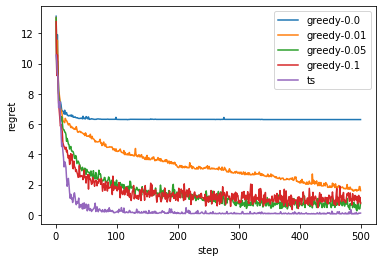

In [14]:
df_concat = pd.concat(results)
plt_df = df_concat.groupby(['agent', 'step']).agg({'regret':np.mean}).reset_index()
fig, ax = plt.subplots()

for agent_type in agent_types:
    data = plt_df.loc[plt_df['agent'] == agent_type]
    ax.plot(data['step'], data['regret'], label=agent_type)

ax.set_xlabel('step')
ax.set_ylabel('regret')
ax.legend()
plt.show()

# Appendix

## 로그정규분포의 확률밀도함수

로그정규분포의 확률밀도함수를 도출하는 것은 $X\sim N(\mu,\sigma^2)$일 때 $Y=\text{exp}(X)$의 확률밀도함수를 도출하는 것이다. $f(x)=\text{exp}(x)$가 단조증가함수이므로 아래와 같은 전개가 성립한다.

$$
P(Y\leq y)=P(\text{exp}(X)\leq y)=P(X\leq\ln y)=F_X(\ln y)\\
p_Y(y)=\frac{\mathrm{d}}{\mathrm{d}y}P(Y\leq y)=\frac{\mathrm{d}}{\mathrm{d}y}F_X(\ln y)=\frac{\mathrm{d}x}{\mathrm{d}y}\frac{\mathrm{d}}{\mathrm{d}x}F_X(\ln y)=\frac{1}{y}f_X(\ln y)\\
\therefore p_Y(y)=\frac{1}{y\sqrt{2\pi\sigma^2}}\text{exp}\left(-\frac{(\ln y-\mu)^2}{2\sigma^2}\right),\;\;y>0
$$

## 로그정규분포의 평균

위와 같은 확률밀도함수를 갖는 확률변수 $Y$의 평균을 계산해본다. 참고로 $X=\ln Y$라고 하면 $\frac{\mathrm{d}y}{\mathrm{d}x}=\text{exp}(x)$이다(즉, $\mathrm{d}y=\text{exp}(x)\mathrm{d}x$)

$$
\mathbb{E}[Y]=\int_0^\infty\frac{y}{y\sqrt{2\pi\sigma^2}}\text{exp}\left(-\frac{(\ln y-\mu)^2}{2\sigma^2}\right)\mathrm{d}y=\int_{-\infty}^{\infty}\frac{1}{\sqrt{2\pi\sigma^2}}\text{exp}\left(-\frac{(x-\mu)^2}{2\sigma^2}+x\right)\mathrm{d}x
$$

지수부 안을 정리하고, 평균과 분산이 각각 $(\mu-\sigma^2, \sigma^2)$인 정규분포의 성질을 활용하면 아래와 같은 결론을 얻는다.

$$
\mathbb{E}[Y]=\text{exp}\left(\mu+\frac{\sigma^2}{2}\right)\int_{-\infty}^\infty\frac{1}{\sqrt{2\pi\sigma^2}}\text{exp}\left(-\frac{(x-\mu+\sigma^2)^2}{2\sigma^2}\right)\mathrm{d}x=\text{exp}\left(\mu+\frac{\sigma^2}{2}\right)
$$

이를 통해, 위 예시에서와 같이 평균과 분산이 각각 $(\ln\theta-\frac{\widetilde{\sigma}^2}{2}, \widetilde{\sigma}^2)$인 정규분포로부터 로그 정규분포를 도출하면 그 로그 정규분포의 평균은 $\text{exp}\left(\ln\theta-\frac{\widetilde{\sigma}^2}{2}+\frac{\widetilde{\sigma}^2}{2}\right)=\theta$가 됨을 알 수 있다.